# Burnt area mapping using chunk_polygon on UDF

In this notebook classical Normalized Burnt Ratio(NBR) difference is performedon a chunk of polygons. You can find ways to develop your process and use chunk_polygon on a usecase. The method followed in this notebook to compute DNBR is inspired from [UN SPIDER's](https://github.com/UN-SPIDER/burn-severity-mapping-EO) recommended preactices.

(To be noted: chunk_polygon are experimental at the moment)

In [1]:
# import necessary packages
import openeo
from openeo.api.process import Parameter
import json
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# connect with the backend
eoconn = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


User can choose among different backend available [here](https://hub.openeo.org/) to connect to their choice of backend. Regarding the authentication process OpenID connect (oidc) is recommended, but not always straightforward to use. In cases where you are unable to connect with the backend use basic authentication method explained [here](https://openeo.org/documentation/1.0/authentication.html#openid-connect).

In [2]:
# function to load geojson file
def read_json(path: Path) -> dict:
    with open(path) as input:
        field = json.load(input)
        input.close()
    return field

To use the data collection, a user must use the correct backend with the data collection. Then using [load_collection](https://open-eo.github.io/openeo-python-client/datacube_construction.html#the-load-collection-process), they can specify bands, temporal extent (i.e. interested time interval) and even spatial extent. In this example, we have loaded the entire collection so that process (including UDF) can later be applied to spatial chunks. 

In [3]:
# load datacube for beforeand after fire 
before_date = ["2021-01-12","2021-03-12"]
after_date = ["2021-05-18", "2021-07-18"]

before_cube = eoconn.load_collection(
                            "SENTINEL2_L1C_SENTINELHUB",
                            temporal_extent = before_date,
                            bands = ['B08','B12']
                            )
after_cube = eoconn.load_collection(
                            "SENTINEL2_L1C_SENTINELHUB",
                            temporal_extent = after_date,
                            bands = ['B08','B12'],
                            )

Here we tried in presenting a method to create and use UDF as an openEO feature. In a similar manner user can create their own UDF as needed to apply to their data cube. More information on [UDF](https://open-eo.github.io/openeo-python-client/udf.html). The reason to create UDF openEO, is similar to creating a function in general python i.e to avoid recursive script.

Our UDF computes Normalised Burnt Ratio (NBR) from the selected band by performing simple band computation and returns a NBR datacube.

In [4]:
# Create a UDF object from inline source code for computing nbr
my_code = """
from openeo.udf import XarrayDataCube


def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    # access the underlying xarray
    inarr = cube.get_array()

    # nbr
    nir = inarr.loc[:,'B08']
    swir = inarr.loc[:,'B12']
    nbr = (nir-swir)/(nir+swir)
    
    # extend bands dim
    nbr=nbr.expand_dims(dim='bands', axis=-3).assign_coords(bands=['nbr'])
    
    # wrap back to datacube and return
    return XarrayDataCube(nbr)
"""
udf_process = lambda data: data.run_udf(udf=my_code,runtime='python')

We used the chunk_polygon method to apply our UDF over a spatial chunk of the datacube. In the case of a simple process that does not require UDF, you can directly load your spatial extent in the dataset. 

In [5]:
#specify aoi chunks
spatial_param = read_json("cal_aoi_v2.geojson") 

# compute nbr for pre and post datacube
pre_nbr = before_cube.chunk_polygon(chunks=spatial_param,process=udf_process)
post_nbr = after_cube.chunk_polygon(chunks=spatial_param,process=udf_process)

Furthermore, since we loaded our collection for specific time intervals, it can include multiple time dimensions. Thus [reduce_dimension](https://processes.openeo.org/#reduce_dimension) applies a reducer to a data cube dimension by collapsing all the pixel values along the time dimension into an output value computed by the reducer.

In [6]:
# perform time dimension reduction
pre_n = pre_nbr.reduce_dimension(dimension="t", reducer="mean")
post_n = post_nbr.reduce_dimension(dimension="t", reducer="mean")

# find the difference between pre and post image
sub = post_n-pre_n

Once the process is completed, you can also save it as your process using [save_user_defined_process](https://open-eo.github.io/openeo-python-client/udp.html) that can later be used for a similar task. Otherwise, you can download the result either by direct download (in case of the small spatial extent with few processing) or perform create a [batch job](https://open-eo.github.io/openeo-python-client/batch_jobs.html) in case it is a heavy task over a large extent.

In [7]:
#download your output
sub.download("sub_nbr_udf.tiff")

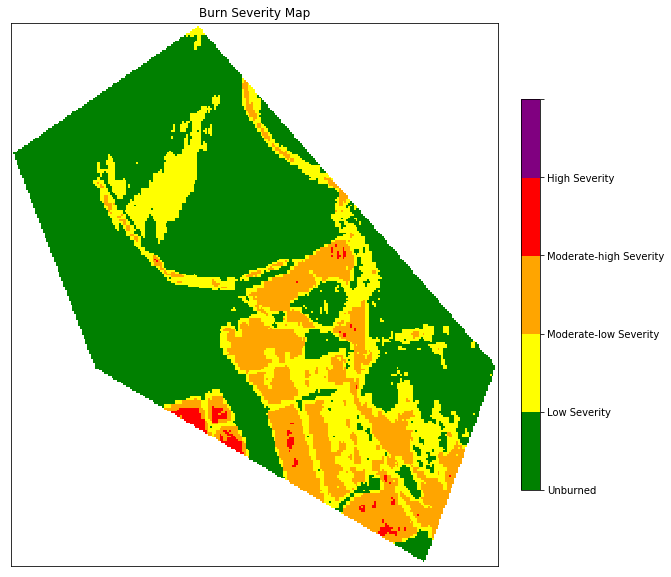

In [8]:
#set colors for plotting and classes based on UN SPIDER recommended practices
import matplotlib
img = rasterio.open("sub_nbr_udf.tiff").read()
cmap = matplotlib.colors.ListedColormap(['green','yellow','orange','red','purple'])
bounds = [-0.5, 0.1, 0.27, 0.440, 0.660, 1.3] 
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cmap.set_over('purple')
cmap.set_under('white')
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(img[0], cmap=cmap,norm=norm)
plt.title('Burn Severity Map')
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=bounds)
cbar.ax.set_yticklabels(['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity'])
plt.show()

The bound set for the legend are based on the description provided in the UN SPIDER guideline.